# Import libraries 

In [2]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import re
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from src.utils.hdf_tools import load_from_hdf_with_regex
from src.visualisation.visualisation import plot_hdf

from src.utils.dataset_utils import align_u_diode_data, drop_quenched_magnets, u_diode_simulation_to_df, \
    u_diode_data_to_df, data_to_xarray, get_u_diode_data_alignment_timestamps

# Load mp3 data

In [3]:
df_mp3_fpa = pd.read_csv("../data/RB_snapshot_context.csv")

In [4]:
#df_events = df_mp3_fpa[(df_mp3_fpa["I_Q_M"] > 10500) & (df_mp3_fpa["dI_dt_from_data"] > 8)]

df_events = df_mp3_fpa[(df_mp3_fpa["I_Q_M"] < 3000) & (df_mp3_fpa["dI_dt_from_data"] > 8)]

In [5]:
df_events

,Unnamed: 0,Unnamed: 0.1,fpa_identifier,Circuit,VoltageNQPS.*U_DIODE,I_Q_M,dt_I_Q_M,dI_dt_from_data,Delta_t(iQPS-PIC),Delta_t(EE_odd-PIC),Delta_t(EE_even-PIC),U_EE_max_ODD,U_EE_max_EVEN,timestamp_fgc,date
0,0,0,RB_RB.A12_1632928721860000000,RB.A12,0,2015.5956,0.02,9.951697,NaN,100.0,596.0,139.602021,140.787116,1632928721860000000,2021-09-29 17:18:41.860000+02:00
8,8,8,RB_RB.A23_1633620586940000000,RB.A23,0,2018.4172,0.02,9.961756,NaN,97.0,602.0,142.993780,140.701681,1633620586940000000,2021-10-07 17:29:46.940000+02:00
16,16,16,RB_RB.A34_1631890796200000000,RB.A34,-1,2016.2545,0.04,9.973677,NaN,101.0,600.0,143.838366,140.926253,1631890796200000000,2021-09-17 16:59:56.200000+02:00
24,24,24,RB_RB.A45_1626276523720000000,RB.A45,0,2005.7019,0.02,9.935712,NaN,100.0,592.0,140.298916,141.809895,1626276523720000000,2021-07-14 17:28:43.720000+02:00
32,32,32,RB_RB.A56_1626362609660000000,RB.A56,0,2019.1566,0.04,9.996886,NaN,99.0,596.0,141.585333,142.376207,1626362609660000000,2021-07-15 17:23:29.660000+02:00
40,40,40,RB_RB.A67_1626447040520000000,RB.A67,0,2021.3243,0.02,9.943771,NaN,102.0,604.0,144.931934,144.289951,1626447040520000000,2021-07-16 16:50:40.520000+02:00
48,48,48,RB_RB.A78_1645804077500000000,RB.A78,0,2011.7837,0.02,9.939322,NaN,100.0,595.0,140.706563,139.044242,1645804077500000000,2022-02-25 16:47:57.500000+01:00
56,56,56,RB_RB.A81_1628694730020000000,RB.A81,0,2020.3885,0.04,9.990143,NaN,98.0,601.0,141.562134,141.808674,1628694730020000000,2021-08-11 17:12:10.020000+02:00


# Load labled data

In [6]:
df_labels = pd.read_excel("../data/UQS0_labels/Outliers_summary_Meas_2021_2022_NoZero_backup.xlsx")

df_labels["magnet"] = df_labels["event"].apply(lambda x: x.split("_")[0])
magnet_list = df_labels["magnet"].unique()

In [7]:
label_names = ["AUTO_unbalanced", "MANUAL_long_unbalanced", "MANUAL_very_long_unbalanced", "MANUAL_boardA_boardB"]

df_magnet_label = pd.DataFrame(np.zeros((len(magnet_list), len(label_names))), columns=label_names, index=magnet_list )
df_magent = pd.DataFrame(magnet_list)
for m in magnet_list:
    df_subset = df_labels[df_labels["magnet"] ==m]
    
    for l in label_names:
        if ((df_subset[l] == "x") | (df_subset[l] == "xx")).any():
            df_magnet_label.loc[m, l] = 1

In [6]:
load_from_hdf_with_regex(file_path / "RB_RB.A12_1647881029880000000.hdf5", regex_list=['U_QS0'])

[        VoltageLogicIQPS/A10L2_A:U_QS0
 -2.765                       -0.000977
 -2.763                       -0.000733
 -2.761                       -0.000489
 -2.759                       -0.000367
 -2.757                       -0.000367
 ...                                ...
  5.416                       -0.000977
  5.418                       -0.000977
  5.420                       -0.000977
  5.422                       -0.000977
  5.424                       -0.000977
 
 [4096 rows x 1 columns],         VoltageLogicIQPS/A10L2_B:U_QS0
 -2.767                       -0.000367
 -2.765                       -0.000123
 -2.763                        0.000121
 -2.761                        0.000121
 -2.759                        0.000121
 ...                                ...
  5.414                       -0.000367
  5.416                       -0.000367
  5.418                       -0.000367
  5.420                       -0.000367
  5.422                       -0.000367
 
 [4096 rows

# Plot all data

In [5]:
file_path = Path('/eos/project/s/steam/measurement_database/RB/data')

data_list = []
data_columns = []
for j, row in df_events.iterrows():
 
    file_name = f"RB_{row['Circuit']}_{row['timestamp_fgc']}"
    data = load_from_hdf_with_regex(file_path / (file_name + ".hdf5"), regex_list=['U_QS0'])
    
    df = u_diode_data_to_df(data, len_data=len(data[0]))
    
    df = df.iloc[60:] #.rolling(15).median()
    
    magnets = [x.split("_")[0] for x in df.filter(regex="_A").columns.values]
    data_columns.append(magnets)
    
    #data_list.append(np.vstack([df.filter(regex="_A"), df.filter(regex="_B")]).T)
    data_list.append(np.vstack([df.filter(regex="_A")]).T)

NameError: name 'df_events' is not defined

In [26]:
na_data = np.stack(data_list)
data = na_data.reshape(-1, na_data.shape[-1])
data.shape

(1232, 4036)

<ipython-input-27-c44e0846e62d>:2: RuntimeWarning: invalid value encountered in greater
  data[data>clip] = clip
<ipython-input-27-c44e0846e62d>:3: RuntimeWarning: invalid value encountered in less
  data[data<-clip] = -clip


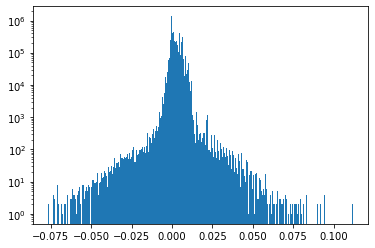

In [27]:
clip = 0.15
data[data>clip] = clip
data[data<-clip] = -clip

data = np.nan_to_num(data)
#data = (data - np.mean(data)) / np.std(data)

plt.hist(data.reshape(-1), bins=300)
plt.yscale("log")
plt.show()

In [28]:
from sklearn.model_selection import train_test_split

magnets = np.array(data_columns).reshape(-1)
y = df_magnet_label.loc[magnets, "AUTO_unbalanced"].values

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(data, y, np.arange(len(y)), test_size=0.15, random_state=1)

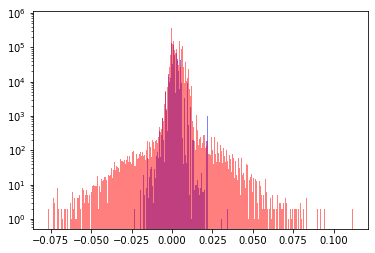

In [29]:
plt.hist(X_train[y_train==0].reshape(-1), bins=300, color="b", alpha=0.5)
plt.hist(X_train[y_train==1].reshape(-1), bins=300, color="r", alpha=0.5)
plt.yscale("log")
plt.show()

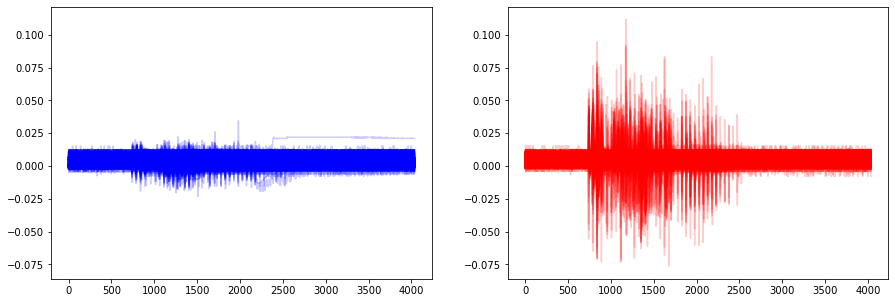

In [30]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(X_train[y_train==0].T, c="b", alpha=0.2)
ax[1].plot(X_train[y_train==1].T, c="r", alpha=0.2)
ax[0].set_ylim(ax[1].get_ylim())

plt.show()

# Predict Labels

In [31]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

# DecisionTreeClassifier

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)

y_pred_train = dt_clf.predict(X_train)

accuracy(y_pred_train, y_train), accuracy(y_pred, y_test)

(1.0, 0.8702702702702703)

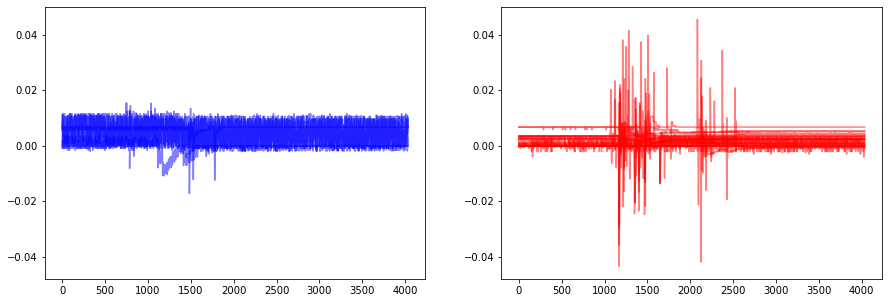

In [33]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(X_test[(y_test==0) & (y_test!=y_pred)].T, c="b", alpha=0.5)
ax[1].plot(X_test[(y_test==1) & (y_test!=y_pred)].T, c="r", alpha=0.5)

ax[0].set_ylim(ax[1].get_ylim())

plt.show()

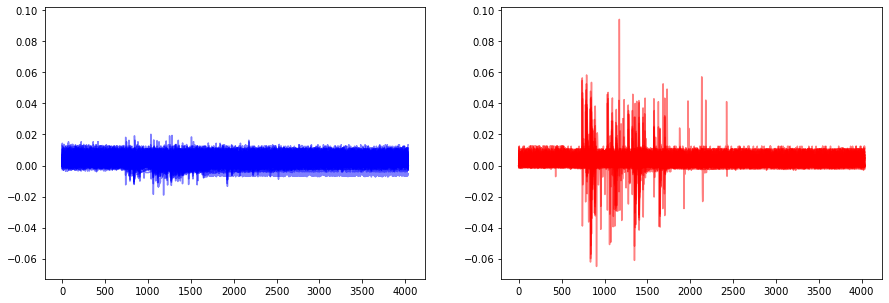

In [34]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(X_test[(y_test==0) & (y_test==y_pred)].T, c="b", alpha=0.5)
ax[1].plot(X_test[(y_test==1) & (y_test==y_pred)].T, c="r", alpha=0.5)

ax[0].set_ylim(ax[1].get_ylim())

plt.show()

# LGBMClassifier

In [18]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(random_state=0) #entropy”, “log_loss”)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

y_pred_train = lgbm_clf.predict(X_train)

accuracy(y_pred_train, y_train), accuracy(y_pred, y_test)

/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(1.0, 0.8162162162162162)